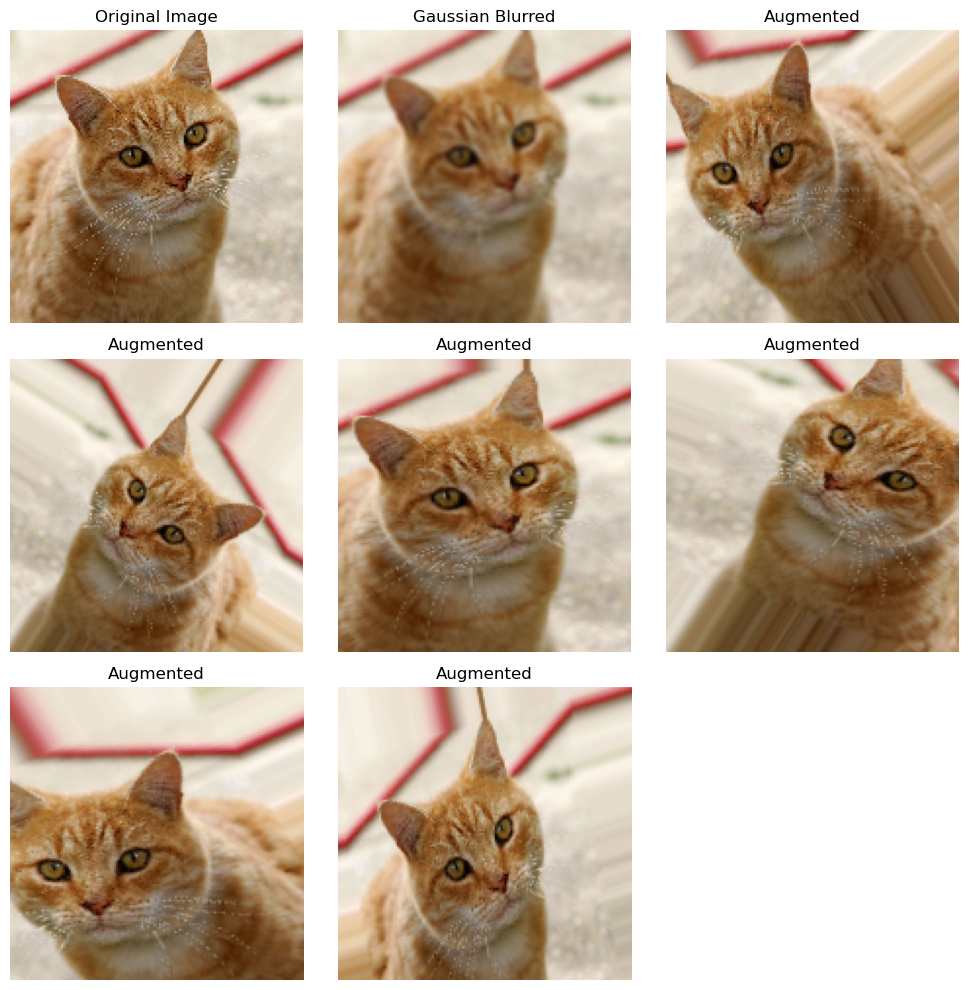

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.7246 - loss: 24.9459
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [12]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Load a sample image
img_path = tf.keras.utils.get_file("cat.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/640px-Cat03.jpg")
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))  
img_array = tf.keras.utils.img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  # Make it batch format

# Apply Gaussian Blur
def apply_gaussian_blur(image_array):
    blurred_image = cv2.GaussianBlur(image_array[0], (5, 5), 0)
    return np.expand_dims(blurred_image, axis=0)

blurred_img_array = apply_gaussian_blur(img_array)

# Image Data Generator with Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create Dummy Labels (3-Class Problem)
num_samples = 10
dummy_labels = np.array([[1, 0, 0]] * num_samples)  # Assuming 3-class one-hot encoded labels

# Generate Augmented Images **WITH LABELS**
augmented_dataset = datagen.flow(
    np.repeat(img_array, num_samples, axis=0),  # Duplicate image 10 times
    dummy_labels,  # Provide labels
    batch_size=1
)

# Plot Original, Augmented, and Blurred Images
plt.figure(figsize=(10, 10))

# Original Image
plt.subplot(3, 3, 1)
plt.imshow(img_array[0].astype('uint8'))
plt.title("Original Image")
plt.axis('off')

# Gaussian Blurred Image
plt.subplot(3, 3, 2)
plt.imshow(blurred_img_array[0].astype('uint8'))
plt.title("Gaussian Blurred")
plt.axis('off')

# Augmented Images (Random 6 examples)
for i in range(3, 9):
    batch, _ = next(augmented_dataset)  # Get next image
    plt.subplot(3, 3, i)
    plt.imshow(batch[0].astype('uint8'))
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Fix Input Shape Issue by using Input() layer
model = Sequential([
    Input(shape=(150, 150, 3)),  # Properly defining input shape
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 Train Model (Now with Labels)
history = model.fit(augmented_dataset, epochs=10, steps_per_epoch=10, verbose=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Unique Classes in y_true: [0]

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



C:\Users\A\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


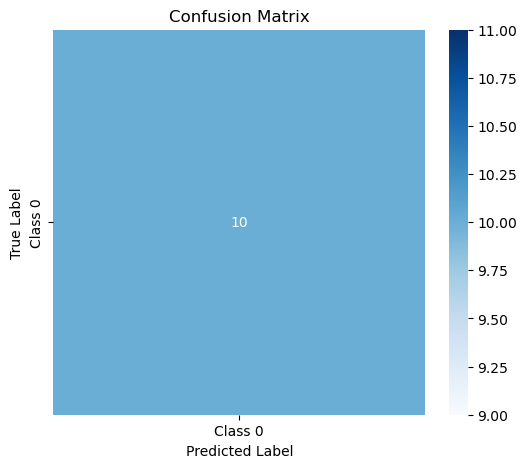

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Evaluate model
test_loss, test_acc = model.evaluate(augmented_dataset, steps=5)
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions
y_pred_prob = model.predict(augmented_dataset, steps=10)  # Probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels

# Ensure `y_true` matches test set size
y_true = np.argmax(dummy_labels[:len(y_pred)], axis=1)

# Check unique classes in y_true
unique_classes = np.unique(y_true)
print("Unique Classes in y_true:", unique_classes)

# Fix: Use only the present labels in target_names
target_names = [f"Class {cls}" for cls in unique_classes]

# Generate classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
